In [17]:
!pip install mpl-scatter-density

In [15]:
import pickle
from typing import Dict,List,Tuple
from functools import partial
import copy
import numpy as np
from omegaconf import OmegaConf,DictConfig
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from scipy.stats import gaussian_kde
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import argparse

import os
import glob
import pickle
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import pandas.api.types as ptypes
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer, LabelEncoder, StandardScaler, MinMaxScaler
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize


def data_to_plot(file_path, data_path):
    

    # Open the prediction outputs 
    with open(file_path, 'rb') as file:
        # Load the dictionary from the pickle file
        dictionary = pickle.load(file)

    # Open the data fed into the model  
    #'aug31st_cluster17_hist100_fut_24.pickle'
    with open(data_path,'rb') as fp:
        data = pickle.load(fp)

    #extract values 
    df = pd.DataFrame({
        'Index': data['data_sets']['test']['id'].flatten(),
        'Flattened_Values': data['data_sets']['test']['target'].flatten(),
    })
    print('predictions', file_path)
    print('data', data_path)

    # Separate the channels into three separate arrays
    channel1 = dictionary['predicted_quantiles'][:, :, 0]
    channel2 = dictionary['predicted_quantiles'][:, :, 1]
    channel3 = dictionary['predicted_quantiles'][:, :, 2]
    
    print('len index =',len(df['Index']))
    print('len flattened values =',len(channel1.flatten()))

    df['pred_01']= channel1.flatten()
    df['pred_05']= channel2.flatten()
    df['pred_09']= channel3.flatten()

    df[['location_id', 'time_id']] = df['Index'].str.split('_', n=1, expand=True)

    df['time_id'] = pd.to_datetime(df['time_id'])
    df['doy']=df['time_id'].dt.dayofyear
    df['location_id'] = df['location_id'].astype(float)
    df = df.sort_values(by=['location_id','time_id'])

    df['year']= df['time_id'].dt.year
    df['month']= df['time_id'].dt.month
    df['day']= df['time_id'].dt.day
    df = df.drop(columns=['Index']) 
    print("len flattened values before", len(df['Flattened_Values']))
    
    #get across site plot values 
    across_site= df.copy()
    across_site = df.groupby(['location_id']).mean().reset_index() 
    across_site['location_id']=across_site['location_id'].astype(float)
    across_site = across_site.sort_values(by='location_id')
    across_site= across_site.rename(columns={'Flattened_Values':'F_site', 'pred_05':'F_site_pred'})

    #get mean seasonal cycle
    grouped = df.groupby(['location_id', 'doy']).mean()
    grouped = grouped.reset_index()
    grouped = grouped.drop(columns=['pred_01','pred_09'])
    grouped= grouped.rename(columns={'location_id':'location_id', 'doy':'doy', 'Flattened_Values':'F_MSC', 'pred_05':'F_MSC_pred'})
    df = df.merge(grouped, on=['doy', 'location_id'], how='left')

    #get seasonal variability plot values 
    a=across_site[['location_id','F_site','F_site_pred' ]]
    df=df.merge(a, on=['location_id'], how='left')
    df['tvar']=df['F_MSC']- df['F_site']
    df['tvar_pred']=df['F_MSC_pred']- df['F_site_pred']

    #get anomaly plot values 
    print("len flattened values after", len(df['Flattened_Values']))
    df['ano']=df['Flattened_Values']- df['F_MSC']
    df['ano_pred']=df['pred_05']- df['F_MSC_pred']
    return df, across_site

def plot(df, across_site, title, figure_path):
    white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624')], N=256)
    white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),                # Pure white at 0
    (1e-20, '#440053'),              # Dark purple at 0.1
    (0.05, '#404388'), 
    (0.2, '#2a788e'),              # Medium blue-green at 0.3
    (0.4, '#21a784'),              # Teal at 0.5
    (0.6, '#78d151'),              # Green at 0.7
    (0.8, '#fde624'),              # Yellow at 0.9
    (1, '#ffffcb')], N=256)                 # Yellow at 1 (maximum value)


    res=[]
    rmse_list=[]
    bias_list = []
    # Create a figure and four subplots
    fig, axes = plt.subplots( figsize=(16, 4))
    plt.axis('off')

    ax1 = fig.add_subplot(141, projection='scatter_density')
    ax2 = fig.add_subplot(142, projection='scatter_density')  # No projection specified for this subplot
    ax3 = fig.add_subplot(143, projection='scatter_density')
    ax4 = fig.add_subplot(144, projection='scatter_density')

    # ________________________________________________________OVERALL ________________________________________________________
    # Calculate Mean Squared Error (MSE)
    rmse = np.sqrt(mean_squared_error(df['Flattened_Values'], df['pred_05']))

    # Calculate R-squared (R2) score
    r2 = r2_score(df['Flattened_Values'], df['pred_05'])

    # Calculate the residuals
    residuals = df['Flattened_Values'] - df['pred_05']

    # Calculate the BIAS (mean value of residuals)
    bias = np.mean(residuals)

    # Create the scatter plot
    #ax1.scatter(x, y, c=z,  s=10, alpha=0.1)
    norm = ImageNormalize(vmin=0, vmax=7000, stretch=LogStretch())    
    density = gaussian_kde(np.vstack([df['Flattened_Values'], df['pred_05']]))(np.vstack([df['Flattened_Values'], df['pred_05']]))
    ax1.scatter(df['Flattened_Values'], df['pred_05'], c=density, cmap=white_viridis, s=10, edgecolor='none')

    ax1.set_title('Overall', fontsize=16)
    ax1.set_ylabel(title, fontsize=16)
    
    # Remove x-tick labels
    ax1.xaxis.set_ticklabels([])

    # Remove y-tick labels
    ax1.yaxis.set_ticklabels([])

    # Plot the line of x=y
    max_value = max(max(df['Flattened_Values']), max(df['pred_05']))
    min_value = min(min(df['Flattened_Values']), min(df['pred_05']))

    ax1.plot([-5, 5], [-5, 5], color='black', linestyle='--')
    # Add text for R-squared and Mean Squared Error
    r_squared = r2
    rmse = rmse
    text = f'$R^2$: {r_squared:.2f}\nRMSE: {rmse:.2f}\nBIAS: {bias:.2f}'
    #ax1.text(1.75, -0.9, text, ha='center', va='center')
    x_s=min_value/1.1
    x_e=max_value/1.4
    y_s=min_value/1.1
    y_e=max_value/1.4
    ax1.set_xlim(x_s, x_e)
    ax1.set_ylim(y_s, y_e)
    text_x= 0.72 * (abs(x_s)+ abs(x_e))+x_s
    text_y= ((abs(y_s)+ abs(y_e))-(0.81 * (abs(y_s)+ abs(y_e))))+y_s
    ax1.text(text_x, text_y, text, ha='center', va='center', fontsize=15)
    ax1.plot([5, 5], [5, 5], color='red', linestyle='--')

    res.append(r_squared)
    rmse_list.append(rmse)
    bias_list.append(bias)
    
    # ________________________________________________________ACROSS SITE ________________________________________________________

    # Calculate Mean Squared Error (MSE)
    rmse = np.sqrt(mean_squared_error(across_site['F_site'], across_site['F_site_pred']))

    # Calculate R-squared (R2) score
    r2 = r2_score(across_site['F_site'],across_site['F_site_pred'])


    # Calculate the residuals
    residuals = across_site['F_site'] - across_site['F_site_pred']
    # Calculate the BIAS (mean value of residuals)
    bias = np.mean(residuals)

    # Create the scatter plot
    #ax2.scatter(x, y, c=z,  s=10, alpha=0.5)
    norm = ImageNormalize(vmin=0, vmax=200, stretch=LogStretch())
    density = gaussian_kde(np.vstack([across_site['F_site'], across_site['F_site_pred']]))(np.vstack([across_site['F_site'], across_site['F_site_pred']]))
    ax2.scatter(across_site['F_site'], across_site['F_site_pred'], c=density, cmap=white_viridis, s=10, edgecolor='none')
    # Plot the line of x=y
    max_value = max(max(across_site['F_site']), max(across_site['F_site_pred']))
    min_value = min(min(across_site['F_site']), min(across_site['F_site_pred']))

    ax2.plot([-5, 5], [-5, 5], color='black', linestyle='--')

    # Add text for R-squared and Mean Squared Error
    r_squared = r2
    rmse = rmse
    text = f'$R^2$: {r_squared:.2f}\nRMSE: {rmse:.2f}\nBIAS: {bias:.2f}'
    #ax2.text(0.6, 0, text, ha='center', va='center')
    x_s=min_value/1
    x_e=max_value/1.8
    y_s=min_value/1
    y_e=max_value/1.8
    ax2.set_xlim(x_s, x_e)
    ax2.set_ylim(y_s, y_e)
    text_x= 0.72 * (abs(x_s)+ abs(x_e))+x_s
    text_y= ((abs(y_s)+ abs(y_e))-(0.81 * (abs(y_s)+ abs(y_e))))+y_s
    ax2.text(text_x, text_y, text, ha='center', va='center', fontsize=15)
    
    res.append(r_squared)
    rmse_list.append(rmse)
    bias_list.append(bias)

    # ________________________________________________________MSC ________________________________________________________
    # Calculate Mean Squared Error (MSE)
    rmse = np.sqrt(mean_squared_error(df['tvar'], df['tvar_pred']))

    # Calculate R-squared (R2) score
    rmse = np.sqrt(mean_squared_error(df['tvar'], df['tvar_pred']))


    # Calculate the residuals
    residuals = df['tvar'] - df['tvar_pred']

    # Calculate the BIAS (mean value of residuals)
    bias = np.mean(residuals)

    #ax3.scatter( x, y, c=z,  s=10, alpha=0.1)
    norm = ImageNormalize(vmin=0, vmax=9000, stretch=LogStretch())
    #ax3.scatter_density( df['tvar'], df['tvar_pred'], color='blue', norm=norm)
    density = gaussian_kde(np.vstack([df['tvar'], df['tvar_pred']]))(np.vstack([df['tvar'], df['tvar_pred']]))
    ax3.scatter(df['tvar'], df['tvar_pred'], c=density, cmap=white_viridis, s=10, edgecolor='none')


    ax3.set_title('Mean Seasonal Cycle')

    # Remove x-tick labels
    ax3.xaxis.set_ticklabels([])

    # Remove y-tick labels
    ax3.yaxis.set_ticklabels([])

    # Plot the line of x=y
    max_value = max(max(df['tvar']), max(df['tvar_pred']))
    min_value = min(min(df['tvar']), min(df['tvar_pred']))
    ax3.plot([min_value-0.5, max_value], [min_value-0.5, max_value], color='black', linestyle='--')

    # Add text for R-squared and Mean Squared Error
    r_squared = r2
    rmse = rmse
    text = f'$R^2$: {r_squared:.2f}\nRMSE: {rmse:.2f}\nBIAS: {bias:.2f}'
    x_s=min_value/1.1
    x_e=max_value/1.5
    y_s=min_value/1.1
    y_e=max_value/1.5
    ax3.set_xlim(x_s, x_e)
    ax3.set_ylim(y_s, y_e)
    text_x= 0.72 * (abs(x_s)+ abs(x_e))+x_s
    text_y= ((abs(y_s)+ abs(y_e))-(0.81 * (abs(y_s)+ abs(y_e))))+y_s
    ax3.text(text_x, text_y, text, ha='center', va='center', fontsize=15)
    
    res.append(r_squared)
    rmse_list.append(rmse)
    bias_list.append(bias)


    #### Anomalies 
    # Calculate Mean Squared Error (MSE)
    rmse = np.sqrt(mean_squared_error(df['ano'], df['ano_pred']))

    # Calculate R-squared (R2) score
    r2 = r2_score(df['ano'],  df['ano_pred'])


    # Calculate the residuals
    residuals = df['ano']-  df['ano_pred']

    # Calculate the BIAS (mean value of residuals)
    bias = np.mean(residuals)
    
    # Create the scatter plot
    norm = ImageNormalize(vmin=2, vmax=3000, stretch=LogStretch())
    #ax4.scatter_density(df['ano'],  df['ano_pred'], color='blue', norm=norm)
    density = gaussian_kde(np.vstack([df['ano'],  df['ano_pred']]))(np.vstack([df['ano'],  df['ano_pred']]))
    ax4.scatter(df['ano'],  df['ano_pred'], c=density, cmap=white_viridis, s=10, edgecolor='none')

    # Plot the line of x=y    
    ax4.plot([-0.25, 0.25], [-0.25, 0.25], color='black', linestyle='--')

    # Add text for R-squared and Mean Squared Error
    r_squared = r2
    rmse = rmse
    text = f'$R^2$: {r_squared:.2f}\nRMSE: {rmse:.2f}\nBIAS: {bias:.2f}'

    x_s=-0.05
    x_e=0.05
    y_s=-0.05
    y_e=0.05
    ax4.set_xlim(-0.05, 0.05)
    ax4.set_ylim(-0.05, 0.05)

    text_x= 0.72 * (abs(-0.05)+ abs(0.05))+-0.05
    text_y= ((abs(y_s)+ abs(y_e))-(0.81 * (abs(y_s)+ abs(y_e))))+y_s
    ax4.text(text_x, text_y, text, ha='center', va='center', fontsize=15)

    res.append(r_squared)
    rmse_list.append(rmse)
    bias_list.append(bias)


    # Set titles for each subplot
    ax2.set_title('Among site', fontsize=16)
    ax3.set_title('Seasonal', fontsize=16)
    ax4.set_title('Anomalies', fontsize=16)

    # Adjust the spacing between subplots
    ax2.set_title('Among site', fontsize=16)
    ax3.set_title('Seasonal', fontsize=16)
    ax4.set_title('Anomalies', fontsize=16)
    

    # Remove spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.xticks([])
    plt.yticks([])
    fig.patch.set_visible(False)
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Hide the figure patch (the background)
    fig.patch.set_visible(False)
    
    # Show the figure
    print(res)
    print(rmse_list)
    print(bias_list)
    # Show the figure
    plt.savefig(figure_path)
    
    


predictions /home/jovyan/phenology-ml-clm/data/predictions/USMMS_06082025.pkl
data /home/jovyan/phenology-ml-clm/data/sorted_BDT_50_20_merged_1982_2021_US_MMS.pkl
len index = 1010
len flattened values = 1010
len flattened values before 1010
len flattened values after 1010
[0.9996633529663086, 0.9201655983924866, 0.9201655983924866, 0.9848772287368774]
[np.float64(0.018445145694448203), np.float64(0.008400011019177514), np.float64(0.016273976930149158), np.float64(0.0021649892058668275)]
[np.float32(0.008200696), np.float32(0.008191023), np.float32(1.5439669e-08), np.float32(8.852175e-11)]


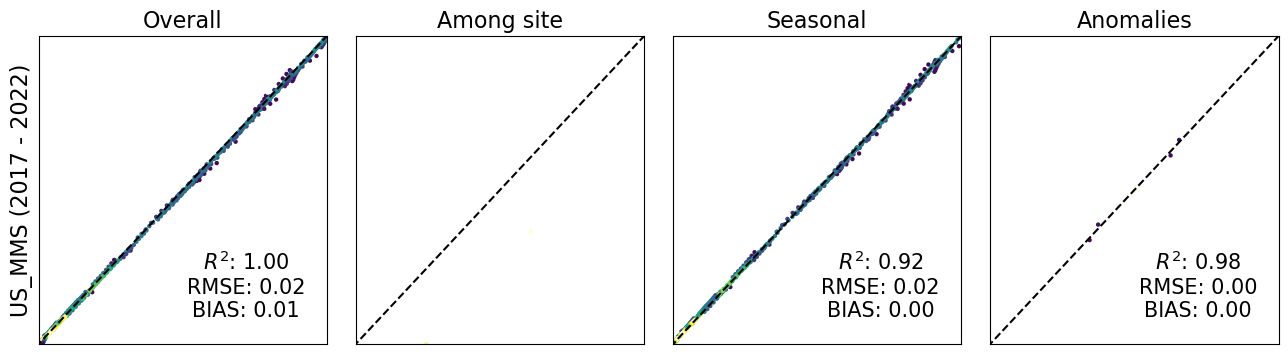

In [16]:
filename = "/home/jovyan/phenology-ml-clm/data/predictions/USMMS_06082025.pkl" #pred_path
data_path = "/home/jovyan/phenology-ml-clm/data/sorted_BDT_50_20_merged_1982_2021_US_MMS.pkl"
pred_path = "/home/jovyan/phenology-ml-clm/data/predictions/USMMS_06082025.pkl"
figure_path = "/home/jovyan/phenology-ml-clm/figures/USMMS_metrics.png"

title="US_MMS (2017 - 2022)"
df, accross_site = data_to_plot(pred_path, data_path)
plot(df, accross_site , title, figure_path)

In [2]:
!pip install mpl-scatter-density


  Using cached fast_histogram-0.14-cp39-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.5/749.5 kB 12.6 MB/s eta 0:00:00
Using cached fast_histogram-0.14-cp39-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (55 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [mpl-scatter-density]
